This is a partial differential-algebraic equation system (PDAE) solved solved with a PINN model using the DeepXDE library. 

It utilizes resampling, L-BFGS optimization algorithm and residual-based adaptive refinement to improve the accuracy of the model.

<br>
\begin{equation}
\frac{\partial u_1}{\partial t} =  \frac{\partial^2 u_1}{\partial x^2} + u_3*sin(πx)
\end{equation}

<br>
\begin{equation}
\frac{\partial u_2}{\partial t} =  \frac{\partial^2 u_2}{\partial x^2} + u_3*cos(πx)
\end{equation}

<br>
\begin{equation}
0 = u_1*sin(πx) + u_2*cos(πx)-e^{-t}
\end{equation}

<br>
\begin{equation}
\textrm{with initial conditions: }
\end{equation}

<br>
\begin{equation}
u_1(0,x)=sin(πx) \hspace{1cm} u_2(0,x)=cos(πx)
\end{equation}

<br>
\begin{equation}
\frac{\partial u_1(0,x)}{\partial t}=-sin(πx) \hspace{1cm} \frac{\partial u_2(0,x)}{\partial t} = -cos(πx)
\end{equation}

Test losses after 13287 epochs are approximately:

*In accordance to y outputs:* **1.59e-05**, **1.73e-05**, **2.46e-05**

*In accordance to initial conditions:* **7.05e-04**, **1.13e-03**, **2.23e-07**, **1.48e-06**

In [1]:
# Import libraries

!pip install deepxde
import deepxde as dde
import numpy as np
import tensorflow as tf
import math

     |████████████████████████████████| 121 kB 16.0 MB/s 
     |████████████████████████████████| 100 kB 7.5 MB/s 


Deepxde backend not selected or invalid. Assuming tensorflow.compat.v1 for now.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
# Define computational geometry

geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])

In [3]:
# Define PDE system

def pde_system(x, y):
    x1 = x[:, 0:1] # The name is x1 to not be confused with the general input x
    t = x[:, 1:2]
    u1 = y[:, 0:1]
    u2 = y[:, 1:2]
    u3 = y[:, 2:3]
    du1_t = dde.grad.jacobian (y, x, i = 0, j = 0)
    du2_t = dde.grad.jacobian (y, x, i = 1, j = 0)
    du1_xx = dde.grad.hessian (y, x, component = 0, i = 0, j = 0)
    du2_xx = dde.grad.hessian (y, x, component = 1, i = 0, j = 0)
    return [du1_t - du1_xx - u3*tf.sin(np.pi*x1), du2_t - du2_xx - u3*tf.cos(np.pi*x1), u1*tf.sin(np.pi*x1) + u2*tf.cos(np.pi*x1) - tf.exp(-t)]

In [4]:
# Define initial conditions

def boundary (x, _):
    return np.isclose(x[1],0)

def boundary_value_u1(x):
    return tf.sin(np.pi * x[:, 0:1])

def boundary_value_u2(x):
    return tf.cos(np.pi * x[:, 0:1])

def boundary_value_du1_t(x):
    return - tf.sin(np.pi * x[:, 0:1])

def boundary_value_du2_t(x):
    return - tf.cos(np.pi * x[:, 0:1])

ic1 = dde.icbc.DirichletBC(geom, boundary_value_u1, boundary, component = 0)
ic2 = dde.icbc.DirichletBC(geom, boundary_value_u2, boundary, component = 1)
ic3 = dde.icbc.NeumannBC(geom, boundary_value_du1_t, boundary, component = 0)
ic4 = dde.icbc.NeumannBC(geom, boundary_value_du2_t, boundary, component = 1)

In [5]:
# Accumulate all the data for the model

data = dde.data.PDE(geom, pde_system, [ic1, ic2, ic3, ic4], num_domain=500, num_boundary=20, num_test=1000)

/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+502=502. 
  total_n_samples))
/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+24=24. 
  total_n_samples))


In [6]:
# Create the neural network

layer_size = [2] + [60] * 3 + [3]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

In [10]:
# Build and train the model

resampler = dde.callbacks.PDEResidualResampler(period=200)
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

losshistory, train_state = model.train(epochs=8000, callbacks=[resampler])

Compiling model...
Building feed-forward neural network...
'build' took 0.076367 s



/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 1.083929 s

Initializing variables...
Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [5.22e-02, 5.30e-01, 3.03e-01, 5.41e-01, 2.95e-01, 4.98e-01, 4.35e-01]    [5.42e-02, 5.31e-01, 3.02e-01, 5.41e-01, 2.95e-01, 4.98e-01, 4.35e-01]    []  


/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+502=502. 
  total_n_samples))
/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+24=24. 
  total_n_samples))


1000      [1.83e-03, 9.55e-04, 4.89e-03, 1.29e-02, 5.08e-03, 1.44e-04, 6.57e-05]    [1.38e-03, 7.51e-04, 4.06e-03, 1.29e-02, 5.08e-03, 1.44e-04, 6.57e-05]    []  
2000      [8.64e-04, 7.88e-04, 2.65e-03, 5.25e-03, 4.07e-03, 4.60e-05, 8.30e-05]    [6.39e-04, 5.28e-04, 2.11e-03, 5.25e-03, 4.07e-03, 4.60e-05, 8.30e-05]    []  
3000      [9.51e-04, 6.26e-04, 1.75e-03, 1.84e-03, 3.57e-03, 1.86e-03, 1.25e-03]    [8.11e-04, 4.44e-04, 1.39e-03, 1.84e-03, 3.57e-03, 1.86e-03, 1.25e-03]    []  
4000      [4.22e-04, 3.96e-04, 1.30e-03, 5.79e-04, 3.21e-03, 1.96e-05, 2.90e-05]    [3.22e-04, 2.76e-04, 1.02e-03, 5.79e-04, 3.21e-03, 1.96e-05, 2.90e-05]    []  
5000      [3.35e-04, 3.04e-04, 1.07e-03, 2.48e-04, 3.03e-03, 1.47e-05, 1.78e-05]    [2.59e-04, 2.11e-04, 8.51e-04, 2.48e-04, 3.03e-03, 1.47e-05, 1.78e-05]    []  
6000      [2.50e-04, 2.77e-04, 9.19e-04, 1.55e-04, 2.87e-03, 2.30e-04, 7.80e-05]    [1.95e-04, 2.07e-04, 7.32e-04, 1.55e-04, 2.87e-03, 2.30e-04, 7.80e-05]    []  
7000      [2.76e-04, 8

In [11]:
# Compile and train the model with the L-BFGS optimization algorithm

model.compile("L-BFGS")
model.train()

Compiling model...
'compile' took 0.921614 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
8000      [1.72e-04, 2.67e-04, 7.06e-04, 1.38e-04, 2.68e-03, 4.04e-05, 1.11e-04]    [1.26e-04, 2.07e-04, 5.79e-04, 1.38e-04, 2.68e-03, 4.04e-05, 1.11e-04]    []  
9000      [3.97e-05, 6.97e-05, 4.45e-05, 6.12e-04, 1.26e-03, 6.27e-08, 4.61e-06]                                                                                  
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.001908
  Number of iterations: 1850
  Number of functions evaluations: 1943
9943      [2.13e-05, 4.77e-05, 2.54e-05, 7.22e-04, 1.09e-03, 5.39e-08, 1.49e-06]    [1.66e-05, 1.52e-05, 1.69e-05, 7.22e-04, 1.09e-03, 5.39e-08, 1.49e-06]    []  

Best model at step 9943:
  train loss: 1.91e-03
  test loss: 

(<deepxde.model.LossHistory at 0x7f0d765e8dd0>,
 <deepxde.model.TrainState at 0x7f0d765e8c50>)

In [12]:
# Improve models' accuracy using residual-based adaptive refinement

X = geom.random_points(100000)
err = 1

while err > 0.005:
    f = model.predict(X, operator=pde_system)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))

    x_id = np.argmax(err_eq, axis=1)
    p1 = X[x_id[0][0]]
    p2 = X[x_id[1][0]]
    p3 = X[x_id[2][0]]
    print("Adding new points:", p1, p2, p3, "\n")
    data.add_anchors(np.array([p1, p2, p3]))
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile("adam", lr=1e-3)
    model.train(epochs=10000, disregard_previous_best=True, callbacks=[early_stopping])
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

Mean residual: 3.140e-03
Adding new points: [0.0007298  0.00080383] [0.0007298  0.00080383] [0.71933675 0.01222706] 

Compiling model...
'compile' took 0.732191 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
9943      [1.16e-04, 4.35e-04, 2.75e-05, 7.22e-04, 1.09e-03, 5.39e-08, 1.49e-06]    [1.66e-05, 1.52e-05, 1.69e-05, 7.22e-04, 1.09e-03, 5.39e-08, 1.49e-06]    []  
10000     [2.95e-04, 2.27e-04, 1.82e-04, 7.01e-04, 1.16e-03, 5.82e-05, 1.77e-03]    [2.52e-04, 1.36e-04, 1.57e-04, 7.01e-04, 1.16e-03, 5.82e-05, 1.77e-03]    []  
11000     [3.89e-05, 7.62e-05, 7.11e-05, 7.18e-04, 1.13e-03, 8.79e-07, 5.32e-06]    [2.73e-05, 4.74e-05, 6.24e-05, 7.18e-04, 1.13e-03, 8.79e-07, 5.32e-06]    []  
12000     [4.84e-05, 1.04e-04, 1.06e-04, 7.16e-04, 1.14e-03, 9.85e-04, 6.06e-04]    [3.92e-05, 7.68e-05, 9.72e-05, 7.16e-04, 1.14e-03, 9.85e-04, 6.06e-04]    

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


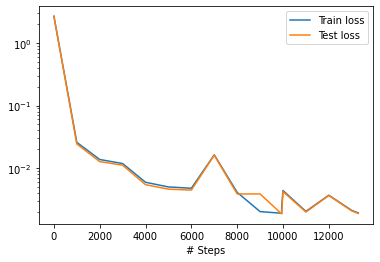

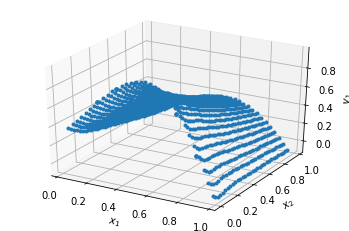

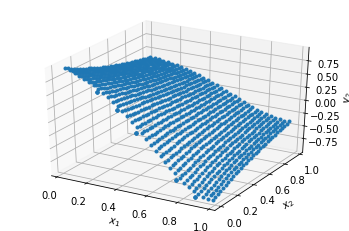

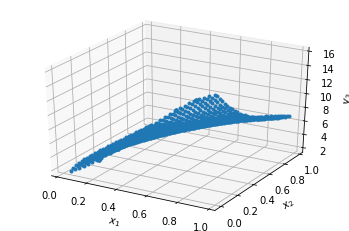

<Figure size 432x288 with 0 Axes>

In [18]:
# Generating plots of the results.

import matplotlib.pyplot as plt

dde.saveplot(losshistory, train_state, issave=True, isplot=True)
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=pde_system)

plt.figure()
plt.show()